# Recommender System
##### Team members: Yingyin Xiao, Dun Lin, Janathon Lin

## Introduction

We are trying to build a recommender system that recommends business to users.
To develop a recommendation system for users, essentially we are looking at their preferences in different categories, which are presumably dependent on the rating and location. Since users are the target, we would generate a model to predict the users' preference specifically.

First of all, we imported the datasets and did visualizing analysis.

In [1]:
# import libraries
import os
import io
import json
import gzip
from collections import defaultdict # shoutout
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# list current directory
os.listdir()

['.DS_Store',
 'places.clean.json.gz',
 'sample.reviews.json',
 'users.clean.json.gz',
 'project.ipynb',
 'reviews.clean.json.gz',
 'users.clean.json',
 'Categories.ipynb',
 '.ipynb_checkpoints',
 'yelp-category.csv']

### Read in a gz file
- since file is too large, we extract the first 200 rows

In [3]:
def readGz(fname):
    gz = gzip.open(fname, 'rb')
    f = io.BufferedReader(gz)
    data = []
    
    counter = 0
    for l in f.readlines():
        if counter > 2000:
            break
        else:
            counter += 1
            data.append(eval(l))
        
    gz.close()
    return data

places = readGz("places.clean.json.gz")

In [5]:
users = readGz("users.clean.json.gz")

In [6]:
# load sample reviews file instead
reviews = []
with open('sample.reviews.json') as f:
    reviews = json.load(f)
    print(len(reviews))

500000


In [7]:
from pandas.io.json import json_normalize
import pandas as pd
places_df = pd.DataFrame.from_dict(json_normalize(places), orient='columns')
users_df = pd.DataFrame.from_dict(json_normalize(users), orient='columns')
reviews_df = pd.DataFrame.from_dict(json_normalize(reviews), orient = 'columns')

In [8]:
reviews_df.groupby('gPlusUserId')['rating'].value_counts().head()

gPlusUserId            rating
100000021336848867366  5.0       1
100000032416892623125  4.0       1
100000036174088924566  5.0       1
100000042779388982190  5.0       1
100000059843227870895  3.0       1
Name: rating, dtype: int64

Examine if the column "closed" affects the rating of the place. If it does, then it should be taken into the consideration of one of the features that determines the recommender system.

In [9]:
combo = reviews_df.merge(places_df, how = 'inner', on = 'gPlusPlaceId')
display((combo.closed == True).mean())

0.016666666666666666

closed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

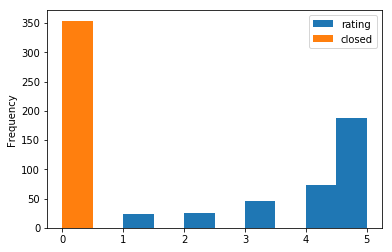

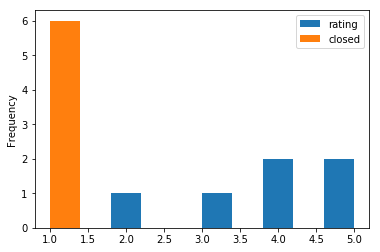

In [10]:
def change(r):
    if r == True:
        return 1
    elif r == False:
        return 0
    else:
        return
combo['closed'] = combo['closed'].apply(change)
(
   combo[['rating','closed']]
    .groupby('closed')
    .plot(kind = 'hist', legend = True))

We could not tell whether business closing would affect the rating, since the difference is not as obvious, so we move to "review time". First, we examine if the year of review affects rating. 

In [15]:
reviews_df['reviewTime'] = pd.to_datetime(reviews_df['reviewTime'])

In [16]:
sorted_rev = reviews_df.sort_values(by = 'reviewTime')
sorted_rev['reviewYear'] = reviews_df.reviewTime.dt.year

In [17]:
sorted_rev[['reviewYear', 'rating']].groupby('reviewYear')['rating'].mean()

reviewYear
1990.0    4.072464
2001.0    4.250000
2002.0    4.043478
2003.0    3.972222
2004.0    3.924138
2005.0    3.969231
2006.0    3.900383
2007.0    3.908696
2008.0    3.806998
2009.0    3.707412
2010.0    3.871208
2011.0    3.981289
2012.0    4.097034
2013.0    4.044226
2014.0    4.094523
Name: rating, dtype: float64

From year 1990 to 2014, we see that the mean of the rating doesn't change too much, which means review of the year is not a big factor that influences people's rating. 

is_null
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: rating, dtype: object

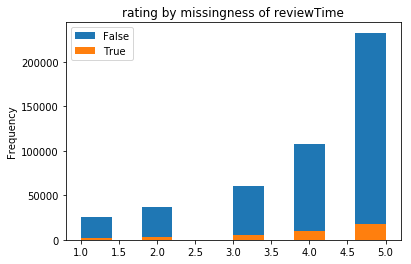

In [18]:
(
    sorted_rev
    .assign(is_null=sorted_rev.reviewYear.isnull())
    .groupby('is_null')        
    .rating
    .plot(kind='hist', legend=True, title='rating by missingness of reviewTime')
)

Though the mean tells us the difference is trivial, missingness of the reviewTime vs. ratings tells us reviewTime is not missing completely by random, indicating that they have correlation, so we put reviewTime into one of the features.

validation set should be the top 5 businesses recommended. Now I am putting the information into one table, so we could use the model.

## Approach

### Categories
- Based on a user’s previous reviews, we want to recommend businesses that relate to their categories
Using a Yelp list of possible categories, we can categorize businesses into 22 types. Then make recommendations using businesses that categorized into the same type.

In [20]:
def separate(lst):
    output = []
    if lst is None:
        return
    for i in lst:
        output += i.split()
    return output

In [21]:
# Separate categories
df1 = reviews_df
df1['categories'] = df1['categories'].apply(separate)

# Import
df3 = pd.read_csv('yelp-category.csv')
df3['Secondary Categories'] = df3['Secondary Categories'].apply(lambda x: x.split())

# Separate elements of a list into one list on whitespace; i.e. ['a b', 'c d'] --> ['a', 'b', 'c', 'd']
df3 = df3.groupby('Primary Categories').agg({'Secondary Categories': 'sum'}).reset_index()

# Identify Group Categories
primary_list = df3['Primary Categories'].value_counts().index.tolist()

# Category List; Key is Primary Category, Value is List of Elements of Second Category
cat_list = dict(zip(df3['Primary Categories'], df3['Secondary Categories']))

# Introduce New Columns into original df
for col in primary_list:
    print(col) # progress bar
    df1[col] = pd.Series([(lambda x: any(i in cat_list[col] for i in x))(x) \
                          for x in df1['categories'] if x is not None])
# output
df1

Food
Arts Entertainment
Nightlife
Health Medical
Shopping
Local Services
Financial Services
Real Estate
Beauty Spas
Pets
Education
Event Planning Services
Restaurants
Religious Organizations
Mass Media
Public Services Government
Home Services
Professional Services
Automotive
Active Life
Hotels Travel


,categories,gPlusPlaceId,gPlusUserId,rating,reviewText,reviewTime,reviewerName,unixReviewTime,Food,Arts Entertainment,...,Event Planning Services,Restaurants,Religious Organizations,Mass Media,Public Services Government,Home Services,Professional Services,Automotive,Active Life,Hotels Travel
0,"[Liquor, Store]",114925821516688138194,116425610241236691097,5.0,Very nice and friendly. Good prices period!,2014-01-10,Larry Stecklein,1.389399e+09,True,False,...,False,False,False,False,False,False,False,False,False,False
1,[Restaurant],114682145364484181515,103860393153033344115,3.0,None,2012-10-22,Mossad Ibrahim,1.350939e+09,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"[Air, Duct, Cleaning, Service]",115669271055428738535,113081498166076457035,5.0,These guys know their stuff. They went above a...,2013-01-13,Christopher Sherlock,1.358116e+09,True,False,...,False,False,False,False,False,True,True,True,True,True
3,"[Pizza, Restaurant, European, Restaurant, Ital...",111941167660939978882,106153641177787026098,5.0,I love this place. It is the best pizza place ...,2012-10-17,joseph ventura,1.350504e+09,False,False,...,False,True,False,False,False,False,False,False,False,False
4,"[Stores, and, Shopping]",110391771625004866921,117155856496626773171,5.0,None,2013-11-22,Mahmoud Arafa,1.385143e+09,False,False,...,False,False,False,False,False,False,False,False,False,False
5,"[Hotel, Conference, Center, Wedding, Venue]",109852713940297521047,103770677869830976765,3.0,This hotel receives a 3. Everything was ther...,2013-12-06,blasian FMA,1.386354e+09,False,True,...,True,False,False,False,False,False,False,False,True,True
6,"[Barber, Shop]",107662653277549107610,104586295404256608323,5.0,Thoroughly Impressive. The art of a shave and ...,2012-01-05,Kevin E,1.325780e+09,True,False,...,False,False,False,False,False,False,False,True,False,False
7,"[Sushi, Restaurant]",106125283893529710008,112227921873451203379,5.0,"Best sushi in Toledo, hands down!!!",2012-11-27,Timothy Craig,1.354074e+09,False,False,...,False,True,False,False,False,False,False,False,False,False
8,"[Dental, Clinic, Cosmetic, Dentist]",116541407946218420572,106696123708364240150,5.0,I highly recommend McKinney Dentist to all my ...,2013-02-18,Leslie Hans,1.361236e+09,False,False,...,False,False,False,False,False,False,False,False,False,False
9,"[Department, Store]",105604475535252952337,100788862244810273226,3.0,Seriously! I know there are still employees in...,2013-06-03,Jenn Worthington,1.370328e+09,True,False,...,False,False,False,False,True,False,False,False,False,False


From here we know what does the categories belong to.

# GPS
- By merging data from where a user makes reviews, we can see the GPS location average of where to make recommendations 
    - Ideally with extra time, we can employ a clustering algorithm and avoid outliers such as one time travel locations for each user
- Then by using a k-NN algorithm, we should be able to find businesses that are closest to the user

In [35]:
%%capture
sample_reviews = reviews_df
places = places_df
users = users_df
sample_reviews_gps = sample_reviews[['gPlusPlaceId', 'gPlusUserId', 'rating', 'reviewTime']]
places_gps = places[['closed', 'gPlusPlaceId', 'gps']]
places_gps['gPlusPlaceId'] = places_gps['gPlusPlaceId'].astype(float)
users_gps = users[['gPlusUserId']]
users_gps['gPlusUserId'] = users_gps['gPlusUserId'].astype(float)


In [36]:
%%capture
sample_reviews_gps.gPlusPlaceId = sample_reviews_gps['gPlusPlaceId'].astype(float)
sample_reviews_gps.gPlusUserId = sample_reviews_gps['gPlusUserId'].astype(float)

In [29]:
merged = sample_reviews_gps.merge(places_gps, on='gPlusPlaceId')
merged.head()

,gPlusPlaceId,gPlusUserId,rating,reviewTime,closed,gps
0,1.130389e+20,1.159144e+20,5.0,2014-03-20,False,"[27.813431, -82.60796]"
1,1.090884e+20,1.023256e+20,5.0,2013-03-18,False,"[40.051802, -75.236426]"
2,1.006022e+20,1.061090e+20,5.0,2011-09-29,False,"[46.717622, 11.65158]"
3,1.105433e+20,1.163070e+20,4.0,NaT,False,"[23.427299, 72.654368]"
4,1.014607e+20,1.008819e+20,5.0,2013-05-10,False,"[21.252132, 81.649393]"


In [30]:
from math import cos, sin, atan2, sqrt

def geolocate(geolocations):
    
    x=0
    y=0
    z=0
    for geo in geolocations:
        if geo is None:
            continue
        #Convert lat/lon (must be in radians) to Cartesian coordinates for each location.
        lat = geo[0] * math.pi/180
        lon = geo[1] * math.pi/180
        X = cos(lat) * cos(lon)
        Y = cos(lat) * sin(lon)
        Z = sin(lat)

        #Compute average x, y and z coordinates.
        x += X 
        y += Y 
        z += Z
        
    x /= len(geolocations)
    y /= len(geolocations)
    z /= len(geolocations)

    #Convert average x, y, z coordinate to latitude and longitude.
    Lon = atan2(y, x)
    hyp = sqrt(x * x + y * y)
    Lat = atan2(z, hyp)
    
    return (Lat *  180/math.pi, Lon *  180/math.pi)

In [31]:
list_of_gps = merged.groupby('gPlusUserId').gps.apply(list)

In [33]:
import math
locations = []
for i in range(len(list_of_gps)):
    if list_of_gps.iloc[i] is None:
        continue
    locations.append(geolocate(list_of_gps.iloc[i]))
    
locations

[(40.581469, -73.961767),
 (32.860754, -97.320848),
 (59.418126, 10.484576000000002),
 (36.29582899999999, 139.981826),
 (33.918259, -117.24491),
 (9.742561000000002, -63.16708400000002),
 (23.277928, -106.467908),
 (33.744288000000005, 73.068239),
 (40.815224, -73.95811599999999),
 (41.543575999999995, -96.136931),
 (48.208718, 16.369795000000003),
 (23.974806999999995, 121.611822),
 (45.457688, -73.567618),
 (10.198515999999998, -64.692918),
 (41.951976, -73.994132),
 (21.252131999999996, 81.649393),
 (26.062206, -80.17411799999999),
 (45.535176, -122.862242),
 (53.09542199999999, -0.7603900000000001),
 (8.310219999999997, -62.71572500000001),
 (26.471814000000002, 74.60818100000002),
 (33.004670000000004, -96.986088),
 (-3.0489310000000005, -60.015761000000005),
 (39.075762, -77.136983),
 (-3.0489310000000005, -60.015761000000005),
 (34.07813800000001, -83.918605),
 (35.659839, 139.699568),
 (56.15929899999999, 10.209891),
 (37.796345, -122.21405599999999),
 (29.77631, -95.751877),


## Reviews
- From the k-NN algorithm, we want to balance distance with quality of the business. 
    - We can do this in the future by looking at the travel distances of the user’s past reviews to determine weighting for how far to recommend
- Future ideas:
    - Recommend businesses that have similar number of reviews as the user has been reviewing (this is to avoid suggesting only super popular places to someone who enjoys finding smaller known places)
    - Increase the efficiency of cleaning and smoothing the categories

### What we will do if we have more time
- we are creating a modeling pipeline to predict the top businesses that users will go to with knn classifier

In [37]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [39]:
num_feat = ['rating'] 
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical columns and associated transformers
cat_feat = ['categories', 'reviewYear']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# preprocessing pipeline (put them together)
preproc = ColumnTransformer(transformers=[('num', num_transformer, num_feat), ('cat', cat_transformer, cat_feat)])

pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', LinearRegression())])

## Conclusion:

### Validation
- Using first n years to run the test data, and last few years comparing the recommended restaurant and people’s choice in restaurants for testing accuracy

### Future ideas
- Recommend businesses that have similar number of reviews as the user has been reviewing (this is to avoid suggesting only super popular places to someone who enjoys finding smaller known places)
- Increase the efficiency of cleaning and smoothing the column “categories”
- Using Omnisci Geograph to display the concentration of the businesses in relation to the location of the user to allow closer proximity suggestions
- Check the frequency of the user’s reviews in individual categories and respective reviews to approximate the people’s preference across categories and adjust the respective weighting of categories
